In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import scipy.io
%matplotlib inline

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu_prime(x):
    return np.where(x > 0, 1, 0)

In [4]:
class QuadraticCost(object):
    @staticmethod
    def fn(a, y):
        return 0.5 * np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        return (a-y) * tanh_prime(z)
    
class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    
    @staticmethod
    def delta(z, a, y):
        return (a-y)
    
class Sigmoid(object):
    @staticmethod
    def activate(z):
        return 1.0/(1.0+np.exp(-z))
    
    @staticmethod
    def delta(z):
        return sigmoid(z)*(1-sigmoid(z))
    
class Tanh(object):
    @staticmethod
    def activate(z):
        return np.tanh(z)
    
    @staticmethod
    def delta(z):
        return 1.0 - np.tanh(z)**2
    
class ReLU(object):
    @staticmethod
    def activate(z):
        return np.maximum(0, z)
    
    @staticmethod
    def delta(z):
        return np.where(z > 0, 1, 0)
    
class Network(object):
    def __init__(self, sizes, cost=CrossEntropyCost, func=Sigmoid):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.weight_initializer()
        self.cost=cost
        self.func=func

    def weight_initializer(self):
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = (self.func).activate(np.dot(w, a)+b)
        return a
    
    def train(self, training_data, epochs, learning_rate, save=False):
        n = len(training_data)
        log_file = open("log.txt", "w")  # records loss for each epoch
        log_file.write("Number of epochs: %d, Learning rate: %f\n" % (epochs, learning_rate))
    
        # perform gradient check using numerical approximation
        self.gradient_check(training_data)

        # Initialize a list to store loss for each epoch
        losses = []
    
        for j in range(epochs):
            error_b = [np.zeros(b.shape) for b in self.biases]
            error_w = [np.zeros(w.shape) for w in self.weights]
            for (x, y) in training_data:
                delta_error_b, delta_error_w = self.backprop(x, y)
                error_b = [(eb+deb/n) for eb, deb in zip(error_b, delta_error_b)]
                error_w = [(ew+dew/n) for ew, dew in zip(error_w, delta_error_w)]
    
            loss = self.loss(training_data)
            log_file.write("Epoch %d: %f\n" % (j, loss))
            log_file.flush()  # Flush the file to disk after writing each line
            losses.append(loss)
    
            self.weights = [w-learning_rate*ew for w, ew in zip(self.weights, error_w)]
            self.biases = [b-learning_rate*eb for b, eb in zip(self.biases, error_b)]                
    
        log_file.close()

        if save:
            self.save("model.txt")

    def backprop(self, x, y):
        error_b = [np.zeros(b.shape) for b in self.biases]
        error_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = (self.func).activate(z)
            activations.append(activation)
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        error_w[-1] = np.dot(delta, activations[-2].transpose())
        error_b[-1] = delta
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = (self.func).delta(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            error_w[-l] = np.dot(delta, activations[-l-1].transpose())
            error_b[-l] = delta
        return (error_b, error_w)
    
    def loss(self, data):
        loss = 0
        for x, y in data:
            a = self.feedforward(x)
            # if convert: y = vectorized_result(y)
            loss += self.cost.fn(a, y)/len(data)
        return loss
    
    def save(self, filename):
        # save with the following format: sizes, weights, biases, cost, func line by line
        with open(filename, "w") as f:
            f.write("%s\n" % self.sizes)
            for w in self.weights:
                for row in w:
                    f.write("%s\n" % row)
            for b in self.biases:
                for row in b:
                    f.write("%s\n" % row)
            f.write("%s\n" % self.cost)
            f.write("%s\n" % self.func)
        f.close()

    def test(self, test_data):
        # print(self.feedforward(test_data[0][0]))
        test_results = [(1 if self.feedforward(x) > 0 else -1, y) for (x, y) in test_data]
        accuracy = np.mean([int(x == y) for (x, y) in test_results])
        print("Accuracy: ", accuracy)
        # print(test_results)
        return accuracy

    
    def gradient_check(self, training_data):
        epsilon = 1e-7
        tolerance = 1e-3
        
        for x, y in training_data:
            backprop_b, backprop_w = self.backprop(x, y)

            for i in range(len(self.biases)):
                for j in range(len(self.biases[i])):
                    original_bias = self.biases[i][j]
                    self.biases[i][j] += epsilon
                    loss_plus = self.loss([(x, y)])
                    self.biases[i][j] -= 2*epsilon
                    loss_minus = self.loss([(x, y)])
                    self.biases[i][j] = original_bias
                    numerical_gradient = (loss_plus - loss_minus) / (2*epsilon)

                    if abs(numerical_gradient - backprop_b[i][j]) > tolerance:
                        print("Gradient check failed for bias[%d][%d]: %f vs %f" % (i, j, numerical_gradient, backprop_b[i][j]))

            for i in range(len(self.weights)):
                for j in range(len(self.weights[i])):
                    for k in range(len(self.weights[i][j])):
                        original_weight = self.weights[i][j][k]
                        self.weights[i][j][k] += epsilon
                        loss_plus = self.loss([(x, y)])
                        self.weights[i][j][k] -= 2*epsilon
                        loss_minus = self.loss([(x, y)])
                        self.weights[i][j][k] = original_weight
                        numerical_gradient = (loss_plus - loss_minus) / (2*epsilon)

                        if abs(numerical_gradient - backprop_w[i][j][k]) > tolerance:
                            print("Gradient check failed for weight[%d][%d][%d]: %f vs %f" % (i, j, k, numerical_gradient, backprop_w[i][j][k]))

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [5]:
def load_network():
    file = open("network.txt", "r")
    # format: sizes, cost function, activation function each on a separate line 
    sizes = list(map(int, file.readline().split()))

    # Read the cost function and activation function names
    cost_fn_name = file.readline().strip()
    activation_fn_name = file.readline().strip()

    # Mapping of cost function names to classes
    cost_fn_mapping = {
        "QuadraticCost": QuadraticCost,
        "CrossEntropyCost": CrossEntropyCost
    }

    # Mapping of activation function names to classes
    activation_fn_mapping = {
        "Sigmoid": Sigmoid,
        "Tanh": Tanh
    }

    # Get the actual classes based on the names read from the file
    cost_fn = cost_fn_mapping.get(cost_fn_name, CrossEntropyCost)  # Default to CrossEntropyCost if not found
    activation_fn = activation_fn_mapping.get(activation_fn_name, Sigmoid)  # Default to Sigmoid if not found

    # Initialize the network with the correct classes
    net = Network(sizes, cost=cost_fn, func=activation_fn)
    print(sizes, cost_fn_name, activation_fn_name)
    return net

In [6]:
df = pd.read_csv(r"banana.csv")
df

,At1,At2,Class
0,1.140,-0.114,-1
1,-1.520,-1.150,1
2,-1.050,0.720,-1
3,-0.916,0.397,1
4,-1.090,0.437,1
...,...,...,...
5295,0.335,1.390,1
5296,-1.700,-0.569,1
5297,2.640,1.140,1
5298,0.769,0.772,-1


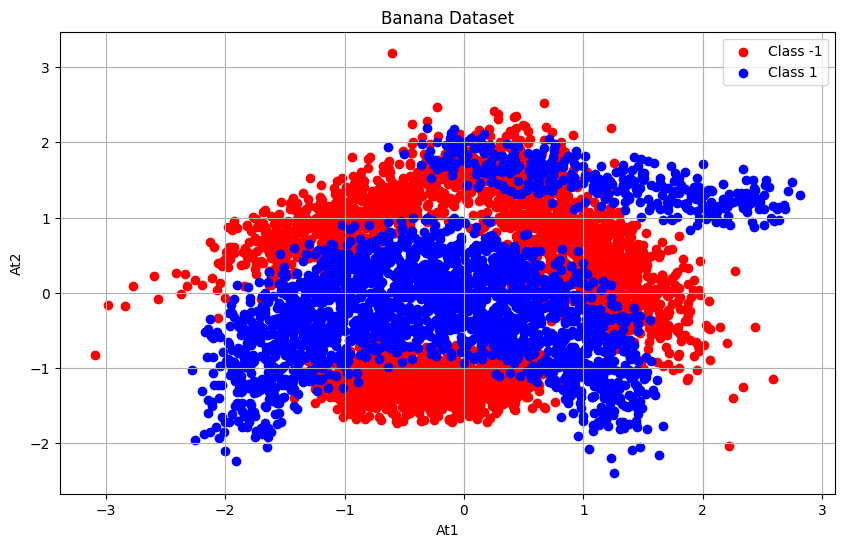

In [7]:
X = df[['At1', 'At2']].values
y = df['Class'].values

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
plt.title('Banana Dataset')
plt.xlabel('At1')
plt.ylabel('At2')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 400/5300, stratify=y)
training_inputs = [np.reshape(x, (len(x), 1)) for x in X_train]
training_results = [np.reshape(y, (1, 1)) for y in y_train]
training_data = list(zip(training_inputs, training_results))

X_train_validation, X_test_test, y_train_validation, y_test_test = train_test_split(X_test, y_test, random_state=0, train_size = 1000/4900, stratify=y_test)
validation_inputs = [np.reshape(x, (len(x), 1)) for x in X_train_validation]
validation_results = [np.reshape(y, (1, 1)) for y in y_train_validation]
validation_data = list(zip(validation_inputs, validation_results))
test_inputs = [np.reshape(x, (len(x), 1)) for x in X_test_test]
test_results = [np.reshape(y, (1, 1)) for y in y_test_test]
test_data = list(zip(test_inputs, test_results))

In [169]:
net2 = load_network()

[2, 32, 24, 1] QuadraticCost Tanh


In [170]:
net2.train(training_data, 500, 0.08)

In [171]:
Network.test(net2, test_data)

Accuracy:  0.9023076923076923


0.9023076923076923

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(log_file_name):
    with open(log_file_name, 'r') as f:
        lines = f.readlines()

    losses = [float(line.split(':')[1]) for line in lines[2:]]

    plt.figure()
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

plot_loss("log.txt")